## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import cv2
import glob
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera Calibration (Code)
Use the chessboard images in the camera_cal/ folder to find a undistortion matrix and save it in a pickle file for later retrieval.

In [2]:
# default parameters
DEFAULT_NX = 9
DEFAULT_NY = 6
DEFAULT_IMG_LOC = "camera_cal/"
DEFAULT_SAVE_NAME = "cal_mtx_dist.p"

def calculate_undist_matrix(nx=DEFAULT_NX, ny=DEFAULT_NY,
                            img_loc=DEFAULT_IMG_LOC,
                            pickle_name=DEFAULT_SAVE_NAME):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(img_loc + '*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    print("Saving calibration mtx and dist to {}".format(img_loc+pickle_name))
    dict_pickle = {}
    dict_pickle["mtx"] = mtx
    dict_pickle["dist"] = dist
    pickle.dump(dict_pickle, open(img_loc+pickle_name, "wb" ))
    return mtx, dist

def get_calibration_mtx_dist(img_loc=DEFAULT_IMG_LOC,
                             pickle_name=DEFAULT_SAVE_NAME):
    pickle_loc = img_loc + pickle_name
    if os.path.isfile(pickle_loc):
        #print("Loading calibration mtx and dist from {}".format(pickle_loc))
        dict_pickle =  pickle.load(open(pickle_loc, "rb"))
        return dict_pickle["mtx"], dict_pickle["dist"]
    else:
        #print("Calculating calubration mtx and dist...")
        return calculate_undist_matrix(img_loc=img_loc, pickle_name=pickle_name)
    
def generate_maps(M, dist, img_size):
    # generate x and y maps to be used with remap for faster undistortion
    mapx, mapy = cv2.initUndistortRectifyMap(M, dist, None, M, img_size, cv2.CV_16SC2)
    return mapx, mapy

## Color / Gradient Threshold Calculation (Code)
White lanes are detected with a absolute sobel threshold in x direction that also satisfy a lightness threshold.  
Yellow lanes are detected by a color threshold of the hue value together with a saturation and lightness threshold.

In [3]:
def color_gradient_threshold(img, sobel_kernel=7, s_thresh=(100, 255), l_thresh=(0,230), l2_thresh=(200, 255), h_thresh=(15, 45), sx_thresh=(20, 255)):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)).astype(np.float)

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    l2_binary = np.zeros_like(l_channel)
    l2_binary[(l_channel >= l2_thresh[0]) & (l_channel <= l2_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((h_binary == 1) & (s_binary == 1) & (l_binary == 1)) | ((sxbinary == 1) & (l2_binary == 1))] = 1
    return combined_binary

## Perspective transform into birds-eye view (code)
Straight lines are visually fitted to pictures with a straight road to calculate the transformation matrix.

In [4]:
src = np.float32([[240,700],[596,450],[686,450],[1075,700]])
dst = np.float32([[380,700],[380,-200],[900,-200],[900,700]])
M_perspective = cv2.getPerspectiveTransform(src, dst)
M_perspective_inv = cv2.getPerspectiveTransform(dst, src)

def apply_perspective_transform(img, M=M_perspective):
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

## Fits a polynomial to the detected pixels of each lane (code)
## Projects the lane back onto the original image (code)
A sliding window over a histogram of pixel values is used to determine the lanes initially.
Subsequent lanes are updated by detected pixels around the current lane lines.
The lane line pixels are used to fit a second order polynomial.
Both lane lines are projected back onto the original (undistorted) image.

In [5]:
def fit_poly_and_draw_lane(undist, binary_warped, left_lane, right_lane, debug=False):    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    
    if not (left_lane.detected and right_lane.detected):
        #print("FIRST")
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)


        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        #print("AFTER")
        left_fit = left_lane.current_fit
        right_fit = right_lane.current_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each lane if lane pixels where detected
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = left_lane.current_fit
    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = right_lane.current_fit
    
    if left_lane.detected and right_lane.detected:
        left_fit = (1-left_lane.change_to_last) * left_lane.current_fit + left_lane.change_to_last * left_fit
        right_fit = (1-right_lane.change_to_last) * right_lane.current_fit + right_lane.change_to_last * right_fit
    else:
        left_lane.detected = True
        right_lane.detected = True
    
    left_lane.current_fit = left_fit
    right_lane.current_fit = right_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if debug:
        # Create an output image to draw on and  visualize the result
        out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        pts = np.array([np.transpose(np.vstack([left_fitx, ploty])), np.transpose(np.vstack([right_fitx, ploty]))])
        cv2.polylines(out_img, np.int32(pts), isClosed=False, color=(255,255,0), thickness=4)
        
        #plt.imshow(out_img)
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        #plt.show()
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_perspective_inv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    if debug:
        return result, out_img
    else:
        return result, None

## Lane Curvature and Car Offset Calculation (code)

In [6]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
fit_correction = np.array([xm_per_pix/(ym_per_pix**2), xm_per_pix/ym_per_pix, xm_per_pix])
    
def get_curverad(fit, y_eval, y_correction=ym_per_pix):
    # calculates the radius of the curvature of a 2nd order polynomial
    return ((1 + (2*fit[0]*y_eval*ym_per_pix + fit[1])**2)**1.5) / np.absolute(2*fit[0])

def calc_curvature(left_lane, right_lane, fit_correction=fit_correction):
    # get the radii of both lanes
    left_curverad = get_curverad(left_lane.current_fit * fit_correction, left_lane.curavture_eval_y)
    right_curverad = get_curverad(right_lane.current_fit * fit_correction, right_lane.curavture_eval_y)
    
    # update the lane objects
    left_lane.radius_of_curvature = left_curverad
    right_lane.radius_of_curvature = right_curverad
    
    # return the average radius of both lanes
    return (left_curverad+right_curverad)/2

def get_lane_position(fit, y_eval):
    # calculate the x value of a polynomial at a given point
    return fit[0]*y_eval**2 + fit[1]*y_eval + fit[2]

def calc_center_offset(left_lane, right_lane, x_correction=xm_per_pix):
    # get the lane position at the bottom of the image
    left_pos = get_lane_position(left_lane.current_fit, left_lane.curavture_eval_y)
    right_pos = get_lane_position(right_lane.current_fit, right_lane.curavture_eval_y)
    
    # determine the offset the the center of the image
    center_offset = (left_lane.image_center - (left_pos + right_pos)/2) * x_correction
    
    # update the lane objects
    left_lane.line_base_pos = left_pos * x_correction
    right_lane.line_base_pos = right_pos * x_correction
    
    return center_offset

## Full Pipeline (code)

In [7]:
# Class to receive the characteristics of each line detection
class Line():
    def __init__(self, change_to_last, img_size):
        # was the line detected in the last iteration?
        self.detected = False
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # the y value at which the curvature is to be evaluated
        self.curavture_eval_y = img_size[1]-1
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #center of image (in px)
        self.image_center = img_size[0]//2
        #distance in meters of lane from x = 0 px
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #exponential decay parameter determining how much the new fit is used to update the current fit
        self.change_to_last = change_to_last

In [8]:
# Pipeline that processes a sequence of image data
class ImageProcessorPipeline:
    def __init__(self, debug=False, img_size=(1280,720), change_to_last=0.1, **thresh_args):
        self.left_lane = Line(change_to_last, img_size)
        self.right_lane = Line(change_to_last, img_size)
        self.ctl = change_to_last
        self.debug = debug
        self.mtx, self.dist = get_calibration_mtx_dist()
        self.mapx, self.mapy = generate_maps(self.mtx, self.dist, img_size)
        self.thresh_args = thresh_args

    def __call__(self, img):
        # Undistort image
        undist = cv2.remap(img, self.mapx, self.mapy, cv2.INTER_LINEAR)
        # Apply color/gradient threshold and get binary image
        #binary_thresh_img = color_gradient_threshold(undist, s_thresh=(20, 255), l2_thresh=(150, 255))
        binary_thresh_img = color_gradient_threshold(undist, **self.thresh_args)
        #original: s_thresh=(100, 255), l2_thresh=(200, 255)
        #challenge: s_thresh=(20, 255), l2_thresh=(150, 255)
        # Warp image to birds-eye view
        binary_warped = apply_perspective_transform(binary_thresh_img)
        # Fit polynomial and draw lane
        result, debug_img = fit_poly_and_draw_lane(undist, binary_warped, self.left_lane, self.right_lane, self.debug)
        
        # Calculate curvature and car offset
        curv = calc_curvature(self.left_lane, self.right_lane)
        car_offset = calc_center_offset(self.left_lane, self.right_lane)
        # Display text of Radius and Offset
        cv2.putText(result, "Radius of Lane Curvature: {0:.2f}m".format(curv), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
        cv2.putText(result, "Car Offset from Lane Center: {0:.2f}m".format(car_offset), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
        
        # Include an image of detected lane lines in binary birds-eyed view to see algorithms decision
        if self.debug:
            result = np.concatenate((result, debug_img), axis=1)
            
        return result

## Visualization of Undistortion and Perspective Transform

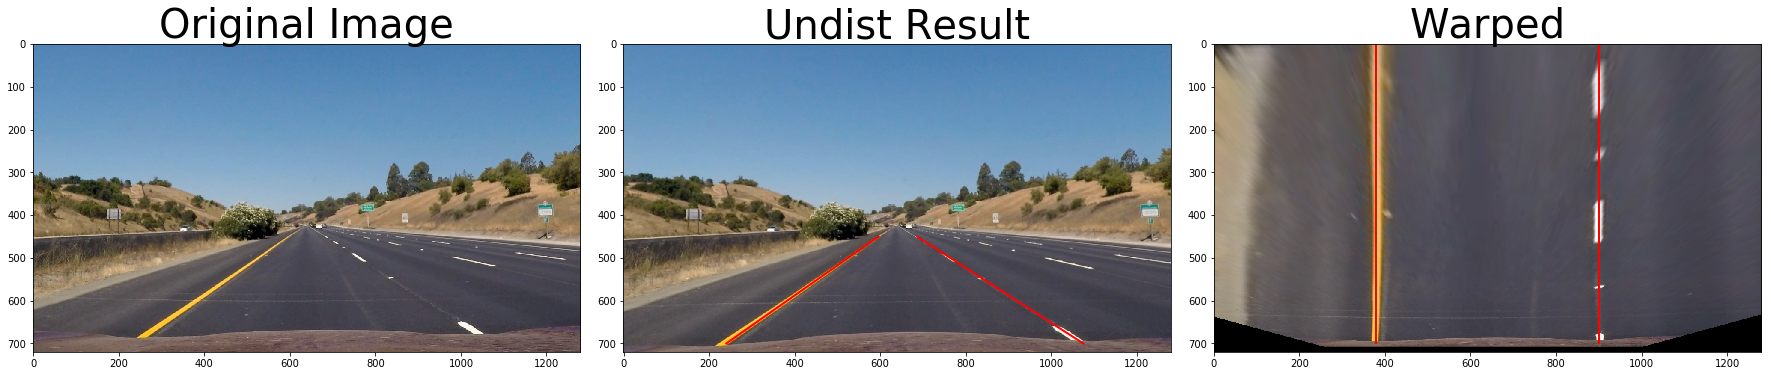

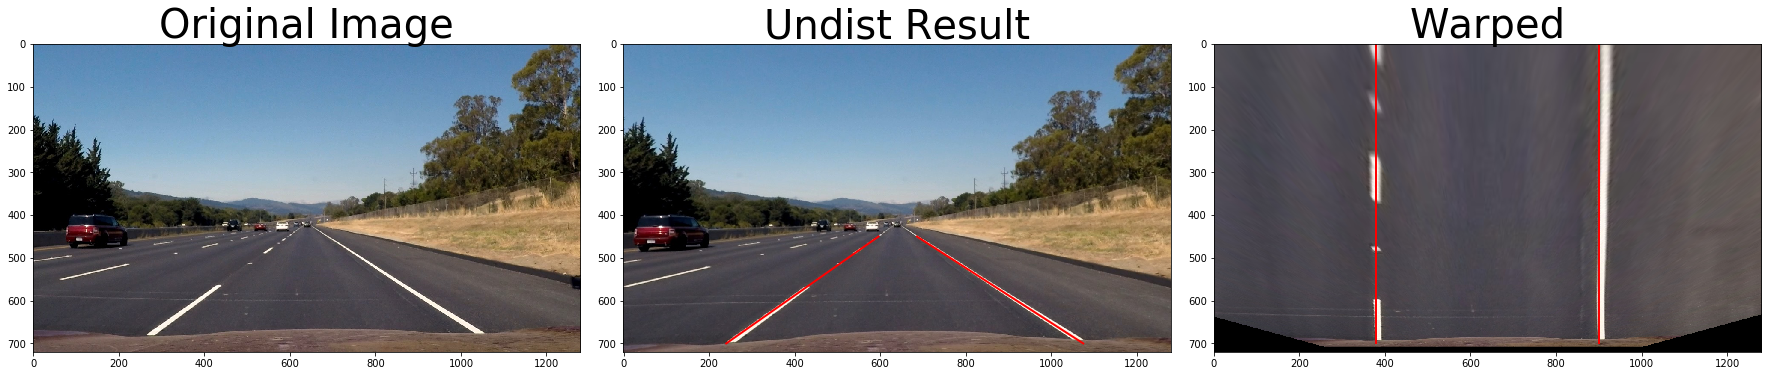

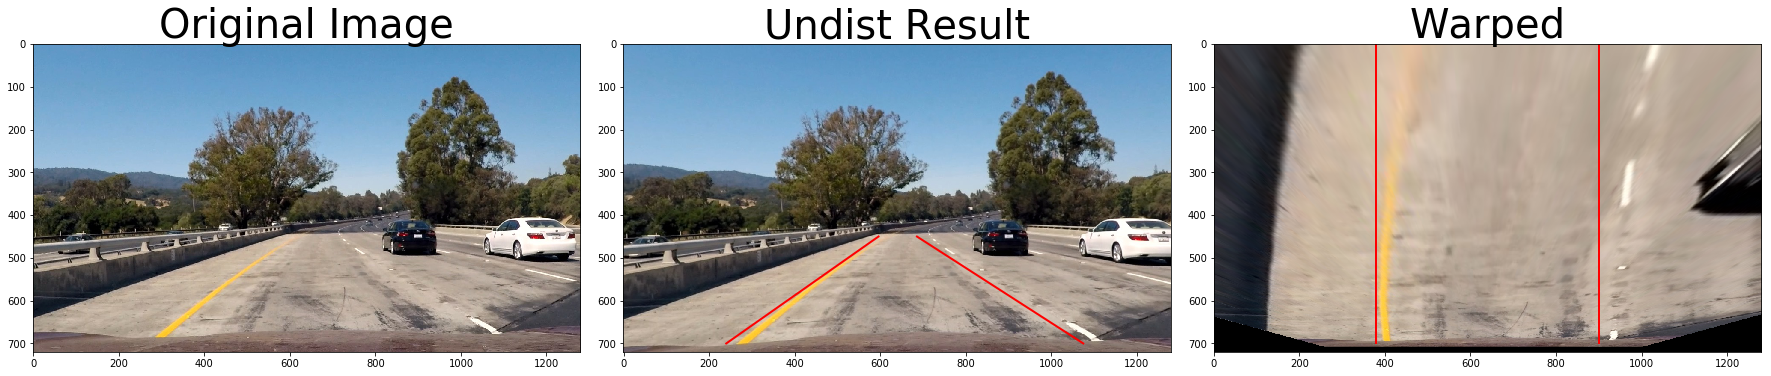

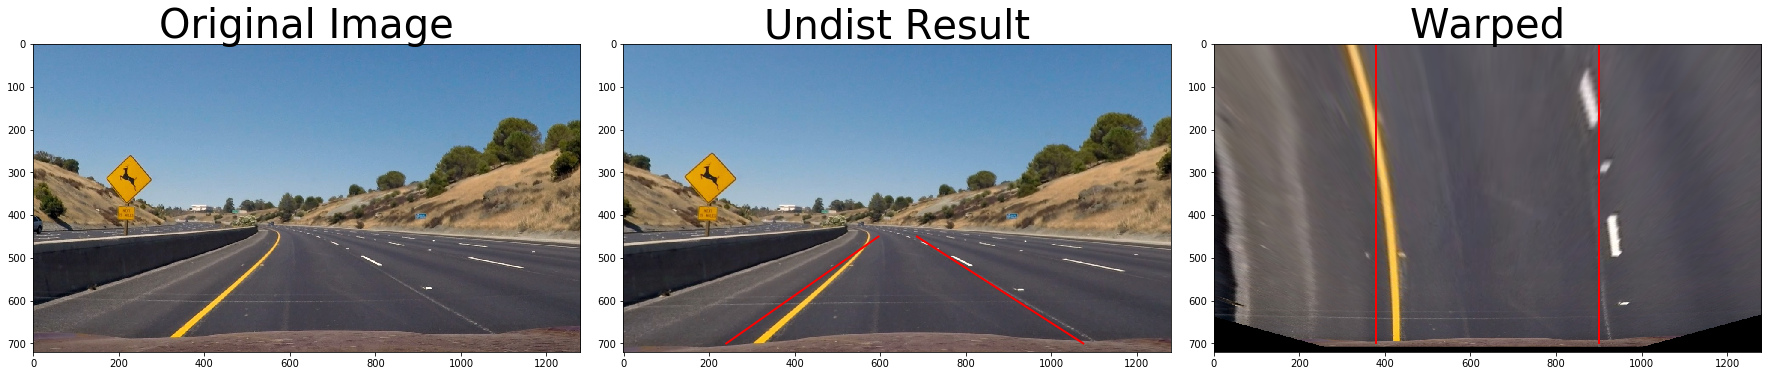

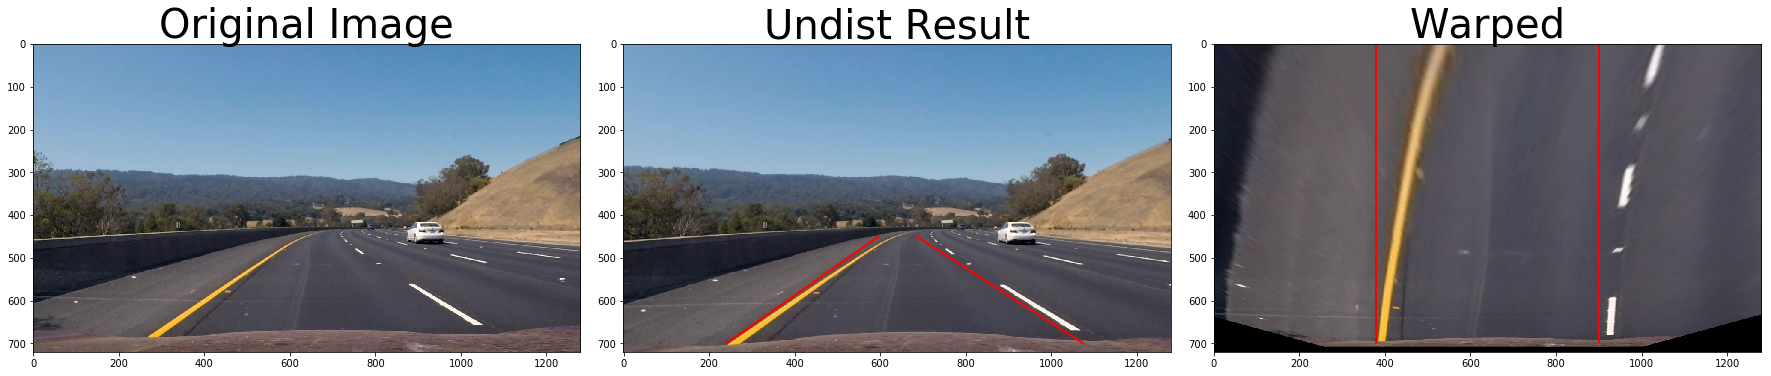

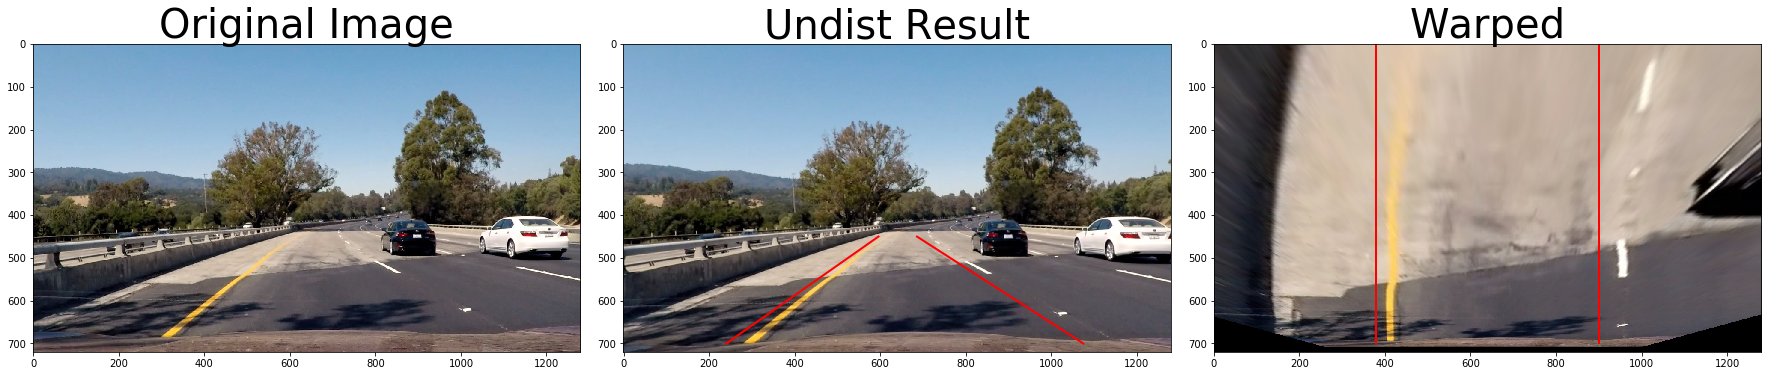

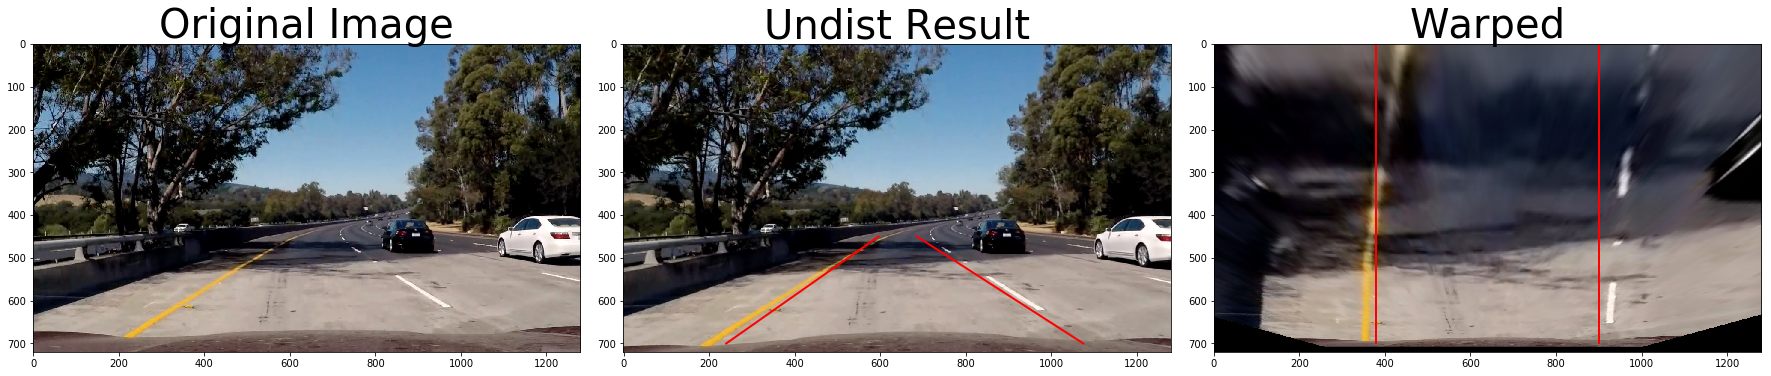

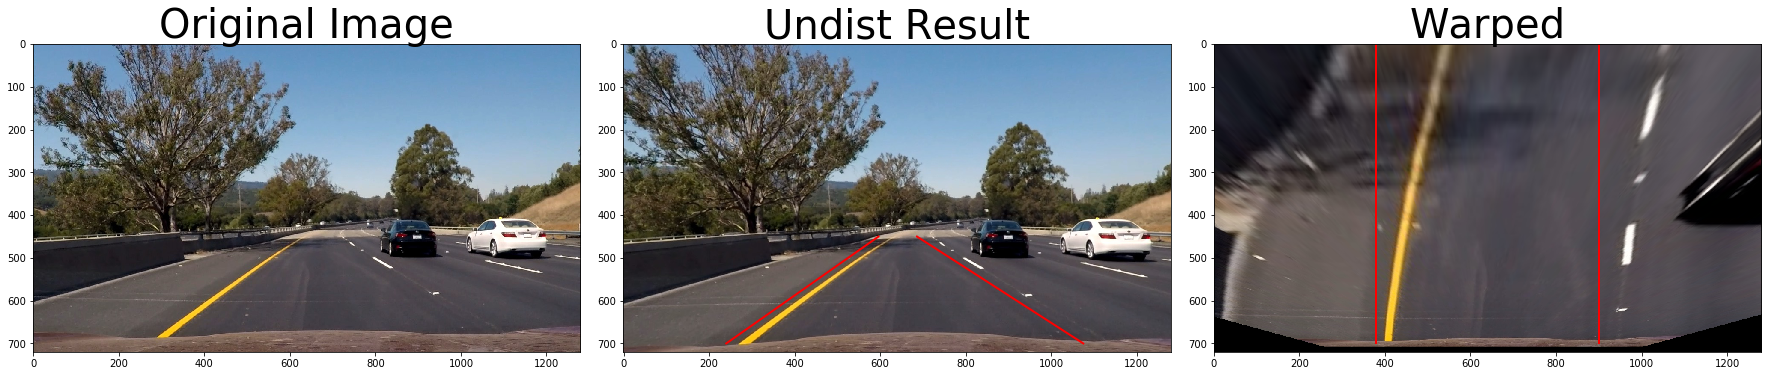

In [9]:
images = glob.glob("test_images/" + '*.jpg')

for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    mtx, dist = get_calibration_mtx_dist()
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    #M = cv2.getPerspectiveTransform(src, dst)
    #warped = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    warped = apply_perspective_transform(img)

    # Plot the result
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(undist)
    ax2.plot(src[:2,0], src[:2,1], color='r', linestyle='-', linewidth=2)
    ax2.plot(src[2:4,0], src[2:4,1], color='r', linestyle='-', linewidth=2)
    ax2.set_title('Undist Result', fontsize=40)

    ax3.imshow(warped)
    ax3.plot(dst[:2,0], [dst[0,1], 0], color='r', linestyle='-', linewidth=2)
    ax3.plot(dst[2:4,0], [0, dst[3,1]], color='r', linestyle='-', linewidth=2)
    ax3.set_title('Warped', fontsize=40)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

## Visualization of Complete Pipeline

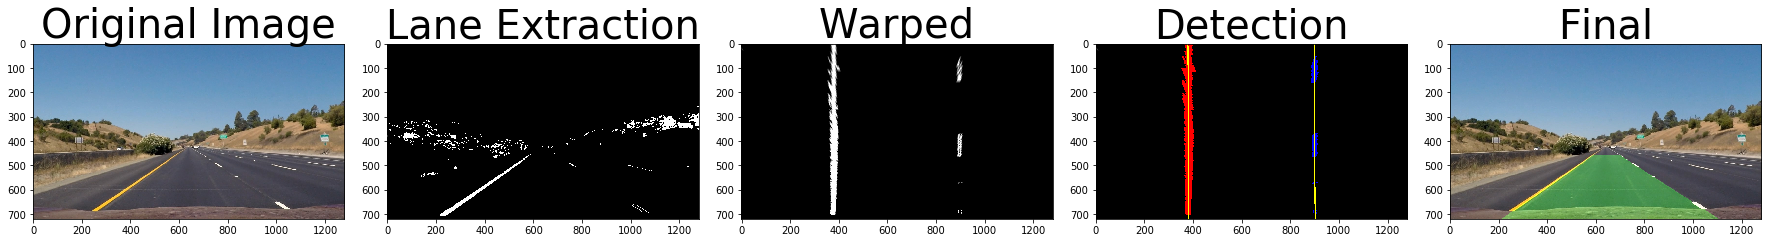

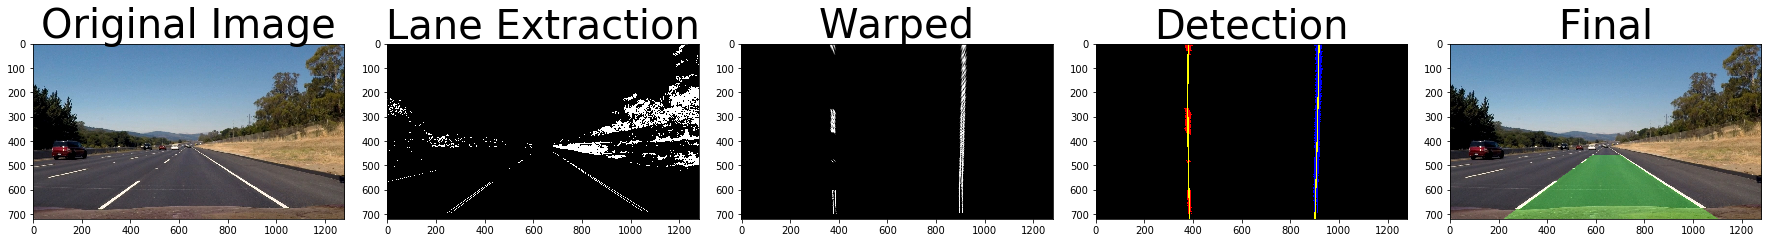

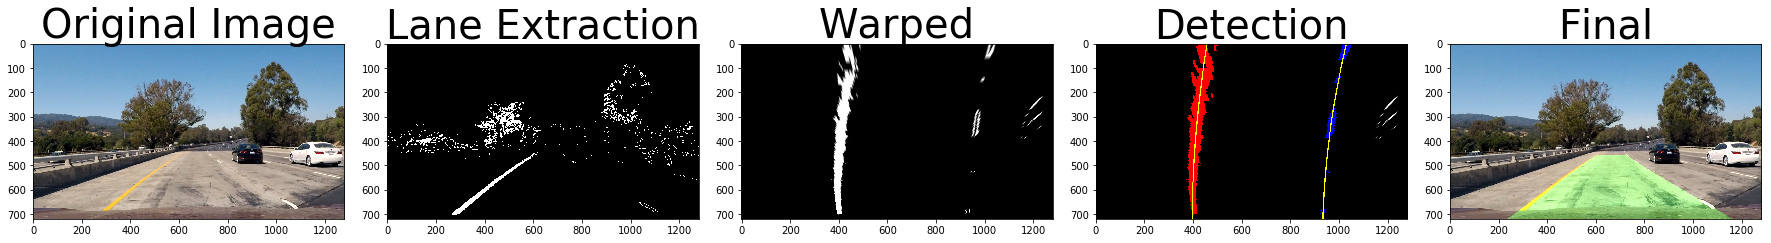

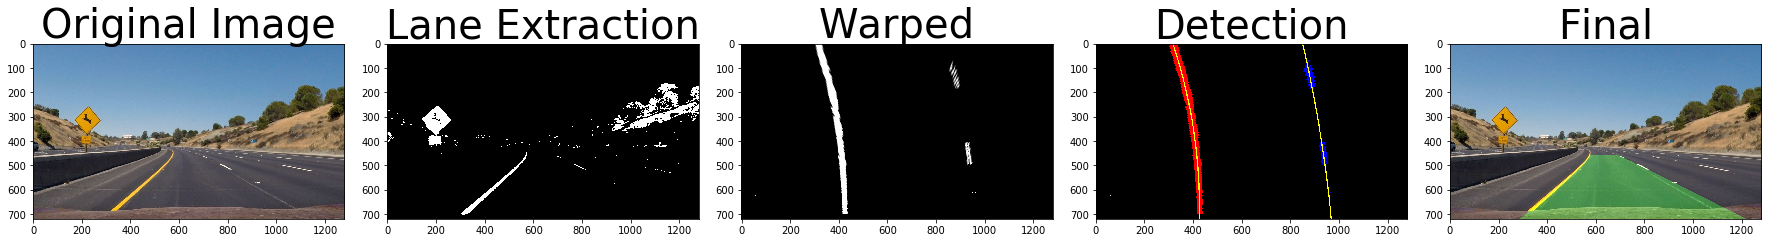

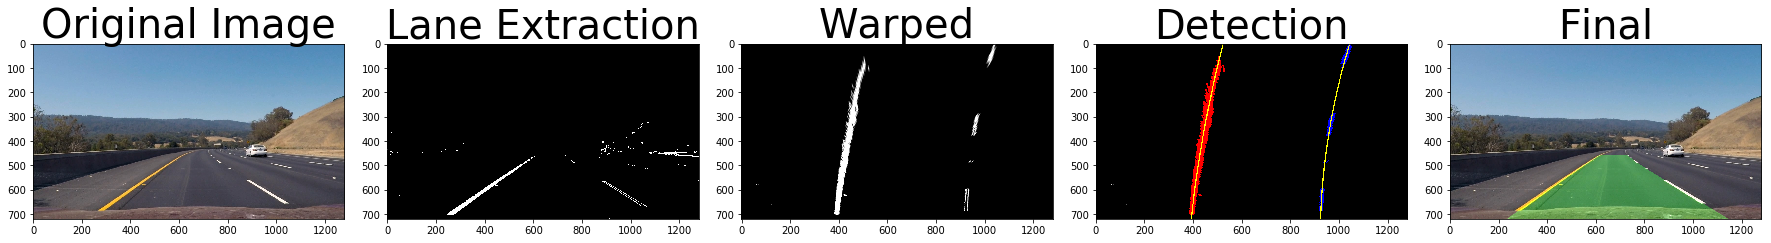

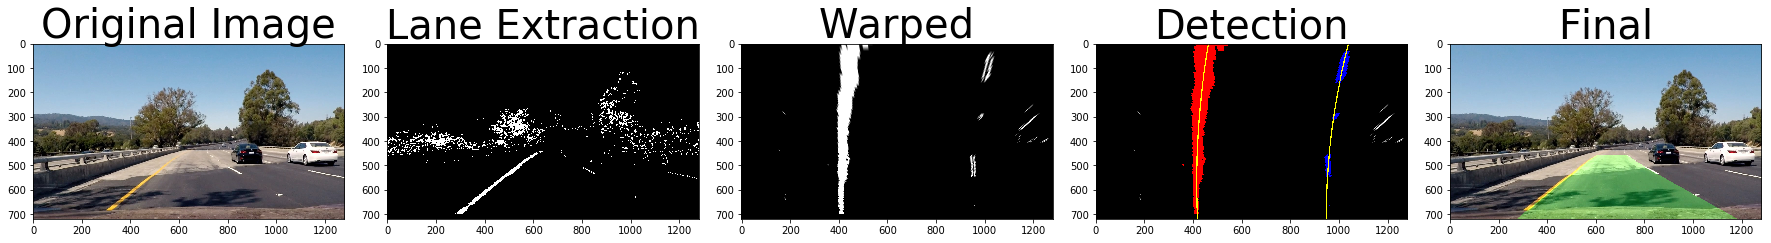

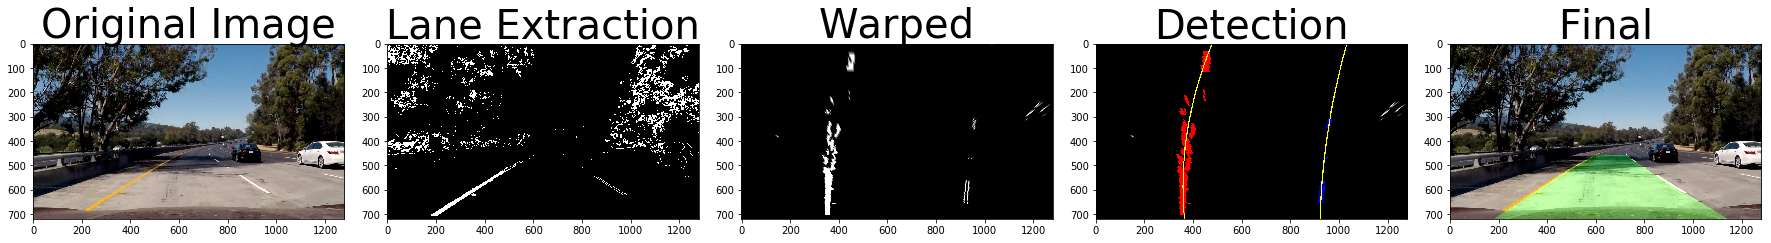

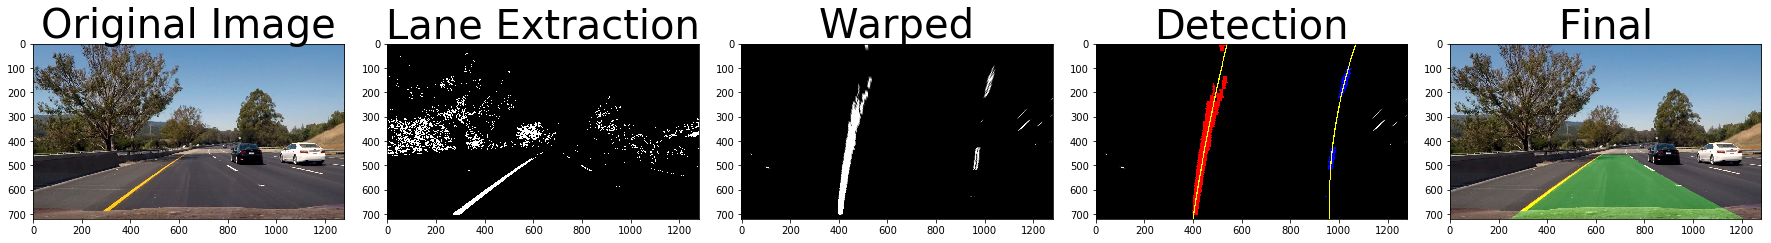

In [10]:
images = glob.glob("test_images/" + '*.jpg')

for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    mtx, dist = get_calibration_mtx_dist()
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    lane_extraction = color_gradient_threshold(undist)
    binary_warped = apply_perspective_transform(lane_extraction)
    
    result, debug = fit_poly_and_draw_lane(img, binary_warped, Line(0.3, img.shape), Line(0.3, img.shape), True)
    
    # Plot the result
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(lane_extraction, cmap="gray", vmin=0, vmax=1)
    ax2.set_title('Lane Extraction', fontsize=40)

    ax3.imshow(binary_warped, cmap="gray", vmin=0, vmax=1)
    ax3.set_title('Warped', fontsize=40)

    ax4.imshow(debug, vmin=0, vmax=1)
    ax4.set_title('Detection', fontsize=40)

    ax5.imshow(result, vmin=0, vmax=1)
    ax5.set_title('Final', fontsize=40)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

In [11]:
from moviepy.editor import VideoFileClip

In [12]:
video_output = "project_video_lane.mp4"
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(ImageProcessorPipeline())
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_lanes.mp4
[MoviePy] Writing video project_video_lanes.mp4


100%|█████████▉| 1260/1261 [05:54<00:00,  3.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lanes.mp4 

CPU times: user 8min 7s, sys: 1min 18s, total: 9min 25s
Wall time: 5min 55s


In [13]:
video_output = "challenge_video_lane.mp4"
clip = VideoFileClip("challenge_video.mp4")
video_clip = clip.fl_image(ImageProcessorPipeline(s_thresh=(20, 255), l2_thresh=(150, 255)))
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_lanes.mp4
[MoviePy] Writing video challenge_video_lanes.mp4


100%|██████████| 485/485 [02:17<00:00,  3.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_lanes.mp4 

CPU times: user 3min 8s, sys: 31 s, total: 3min 39s
Wall time: 2min 18s
